In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310 
from aver5_funcs import get_data
import pickle 
from scipy import stats
import requests,time
from tqdm import tqdm
from time import sleep, perf_counter
from threading import Thread
import numba as nb

def get_time_before(minutes=10):
    return (int(time.time())-minutes*60)*1000
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)

In [6]:
threshold_1st_list=np.arange(0.001,0.041,0.002)
threshold_2nd_list=np.arange(0.001,0.071,0.001)
len(subset_symbols)

346

In [ ]:
@nb.njit
def numba_all(x):
     return np.all(x)

# looped runs

In [ ]:
%%time
concat_data_df=[]
concat_data_inputs=[]
rdf_index=0
for days in [10,20,30,50,60,70,140,200,210]:
    with open(f"9_0_5_analysisdata\data_fetched2_{days:04d}days.pkl","rb") as f:
        data_fetched2 = pickle.load(f)
    #assert False # this takes 35mins to run :(
    #ans_array = [[[1] for _ in threshold_2nd_list] for _ in threshold_1st_list ]
    print("days",days,len(threshold_1st_list))
    for row,threshold_1st in enumerate(threshold_1st_list):
        if row%5==0: print(row,end="")
        for ind,symbol,(df,_) in zip(range(len(subset_symbols)),subset_symbols,data_fetched2):
            changes_5m = ((df.Close-df.Open)/df.Open)
            counts = sum(changes_5m.values>=threshold_1st)
            concat_data_df.append( changes_5m<threshold_1st )
            concat_data_inputs.append( [days,data_fetched2,row,threshold_1st,ind,symbol,df,changes_5m,counts,rdf_index] )
            rdf_index+=1
    print("")

In [ ]:
%%time
newdf= np.asarray([concat_data_df[i].values for i in range(len(concat_data_df))]).T
newdf = pd.DataFrame(newdf)
r_df = newdf.rolling(10).apply(numba_all, engine='numba', raw=True)

In [72]:
%%time
#rdf_index=0
concat_data_inputs_index=0
for days in [10,20,30,50,60,70,140,200,210]:
    with open(f"9_0_5_analysisdata\data_fetched2_{days:04d}days.pkl","rb") as f:
        data_fetched2 = pickle.load(f)
    #assert False # this takes 35mins to run :(
    ans_array = [[[1] for _ in threshold_2nd_list] for _ in threshold_1st_list ]
    print("days",days,len(threshold_1st_list))
    for row,threshold_1st in enumerate(threshold_1st_list):
        if row%5==0: print(row,end="") 
        for ind in range(len(subset_symbols)):
            days,data_fetched2,row,threshold_1st,ind,symbol,df,changes_5m,counts,rdf_index = concat_data_inputs[concat_data_inputs_index]
            concat_data_inputs_index+=1 
            if counts==0: 
                continue  
            r=r_df.iloc[:,rdf_index] 
            a1=np.where(r==1)[0] 
            a2=np.diff(a1) 
            a3=np.where(a2>1)[0] 
            a4 = a1[a3]
            loc1_chng_list = [(df.iloc[loc0+2].Close - df.iloc[loc0+2].Open)/df.iloc[loc0+2].Open for loc0 in a4]
            loc2_chng_list = [(df.iloc[loc0+3].Close - df.iloc[loc0+3].Open)/df.iloc[loc0+3].Open for loc0 in a4]
            for col,threshold_2nd in enumerate(threshold_2nd_list):
                if threshold_1st>threshold_2nd:continue
                if (col%100==0) and col!=0: print(col//100,end="")
                for loc1_chng,loc2_chng  in zip(loc1_chng_list,loc2_chng_list):
                    if loc1_chng>threshold_2nd:
                        ans_array[row][col].append(loc2_chng)
    print("   ",end="")
    with open(f"9_0_5_analysisdata/slow_movement_then_large_ans_array_days{days:04d}_fast.pkl","wb") as f:
        pickle.dump(ans_array,f)

days 10 20
051015   days 20 20
051015   days 30 20
051015   days 50 20
051015   days 60 20
051015   days 70 20
051015   days 140 20
051015   days 200 20
051015   days 210 20
051015   CPU times: total: 2min 51s
Wall time: 3min 30s


# geometric formula to calculate the avg gains/trade

$1+gains = (1+gains/trade)^{counts} = product$

In [7]:
#with open("9_0_5_analysisdata/slow_movement_then_large_ans_array.pkl","wb") as f:
#    pickle.dump(ans_array,f)
#with open("9_0_5_analysisdata/slow_movement_then_large_ans_array.pkl","rb") as f:
#    ans_array = pickle.load(f)
days=30 #[10,20,30,50,60,70,140,200,210]
with open(f"9_0_5_analysisdata/slow_movement_then_large_ans_array_days{days:04d}_fast.pkl","rb") as f:
    ans_array = pickle.load(f)

In [8]:
%%time
ans2_array= [[np.product(1+np.asarray(ans_array[row][col])[1:])-1 for col,threshold_2nd in enumerate(threshold_2nd_list) ] for row,threshold_1st in enumerate(threshold_1st_list)]
counts_array= [[len(ans_array[row][col]) for col,threshold_2nd in enumerate(threshold_2nd_list) ] for row,threshold_1st in enumerate(threshold_1st_list)]
edge = max(np.abs(np.max(ans2_array)),np.abs(np.min(ans2_array)))
geo_avg_array= [[ 0 if len(ans_array[row][col])==1 else np.exp(np.log(np.product(1+np.asarray(ans_array[row][col])[1:]) )/(len(ans_array[row][col])-1))-1
            for col,_ in enumerate(threshold_2nd_list)] 
            for row,_ in enumerate(threshold_1st_list)]


CPU times: total: 15.6 ms
Wall time: 51 ms


0.05157518231635361

Text(0.5, 0, 'threshold2 (spike)')

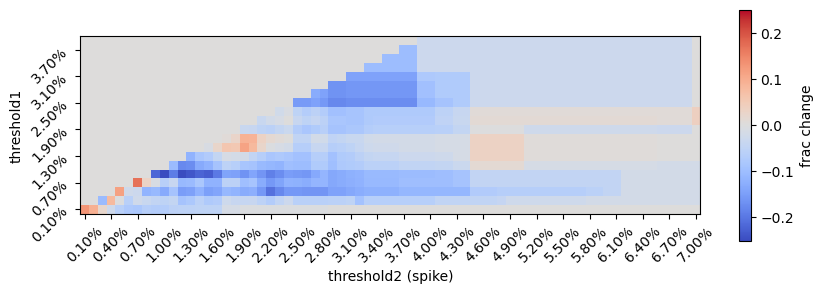

In [9]:
plt.figure(figsize=(10,10))
im = plt.imshow(ans2_array,origin="lower",cmap=plt.cm.coolwarm,vmin=-edge,vmax=edge)
plt.colorbar(im,shrink=0.3,label="frac change")
plt.xticks(ticks=np.arange(len(threshold_2nd_list))[::3],labels=[f"{x:.2%}" for x in threshold_2nd_list][::3],rotation=45)
plt.yticks(ticks=np.arange(len(threshold_1st_list))[::3],labels=[f"{x:.2%}" for x in threshold_1st_list][::3],rotation=45);
plt.ylabel("threshold1")
plt.xlabel("threshold2 (spike)")

Text(0.5, 0, 'threshold2 (spike)')

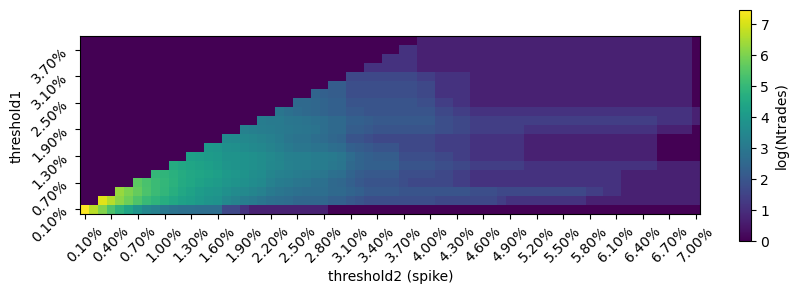

In [10]:
plt.figure(figsize=(10,10))
im = plt.imshow(np.log(counts_array),origin="lower")
plt.colorbar(im,shrink=0.3,label="log(Ntrades)")
plt.xticks(ticks=np.arange(len(threshold_2nd_list))[::3],labels=[f"{x:.2%}" for x in threshold_2nd_list][::3],rotation=45)
plt.yticks(ticks=np.arange(len(threshold_1st_list))[::3],labels=[f"{x:.2%}" for x in threshold_1st_list][::3],rotation=45);
plt.ylabel("threshold1")
plt.xlabel("threshold2 (spike)")

Text(0.5, 0, 'threshold2 (spike)')

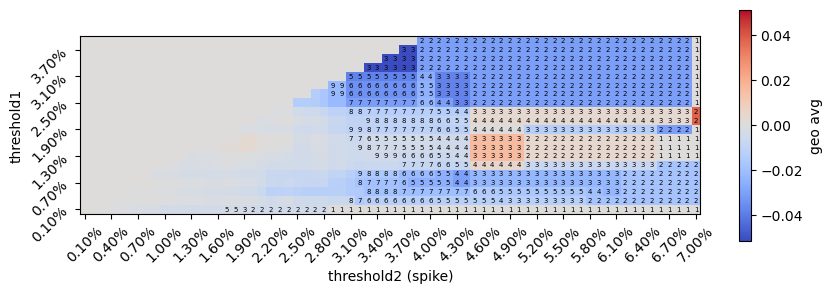

In [13]:
def plot_geo_avg_array(ax,geo_avg_array,threshold_2nd_list,threshold_1st_list):
    edge_geo = max(np.abs(np.max(geo_avg_array)),np.abs(np.min(geo_avg_array)))
    im = ax.imshow(geo_avg_array,origin="lower",cmap=plt.cm.coolwarm,vmin=-edge_geo,vmax=edge_geo)
    plt.colorbar(im,ax=ax,shrink=0.3,label="geo avg")
    ax.set_xticks(ticks=np.arange(len(threshold_2nd_list))[::3])
    ax.set_xticklabels([f"{x:.2%}" for x in threshold_2nd_list][::3],rotation=45)
    ax.set_yticks(ticks=np.arange(len(threshold_1st_list))[::3])
    ax.set_yticklabels([f"{x:.2%}" for x in threshold_1st_list][::3],rotation=45);
    for col,threshold_2nd in enumerate(threshold_2nd_list):
        for row,threshold_1st in enumerate(threshold_1st_list):
            if threshold_1st>threshold_2nd:continue
            if counts_array[row][col]<10:
                ax.text(col,row,f"{counts_array[row][col]}",fontsize=5,va="center",ha="center")
fig,ax=plt.subplots(1,1,figsize=(10,10))
plot_geo_avg_array(ax,geo_avg_array,threshold_2nd_list,threshold_1st_list)
ax.set_ylabel("threshold1")
ax.set_xlabel("threshold2 (spike)")

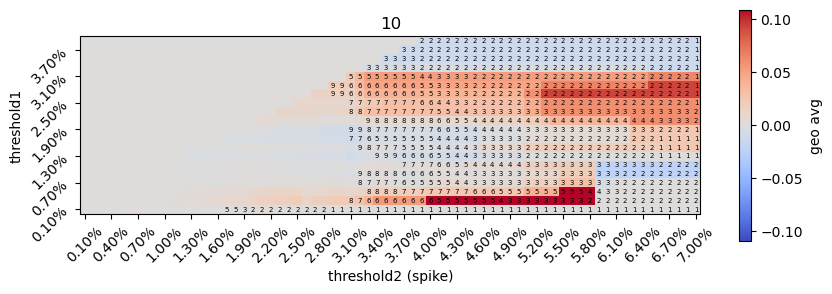

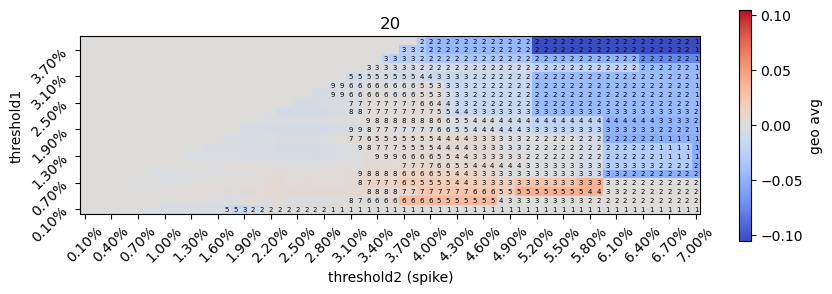

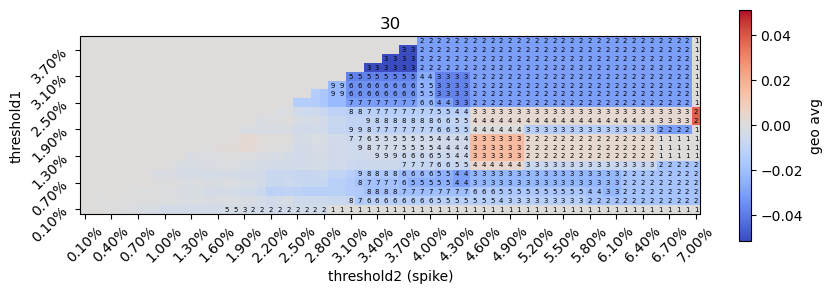

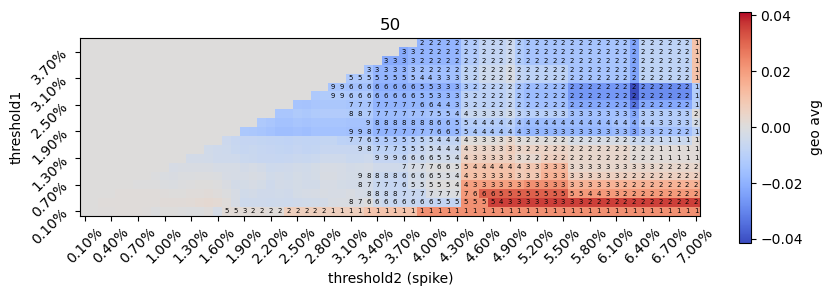

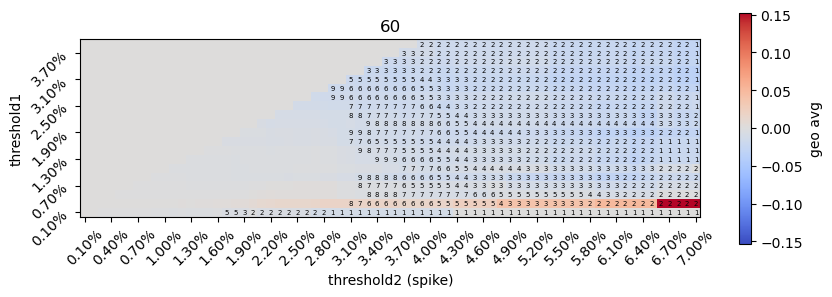

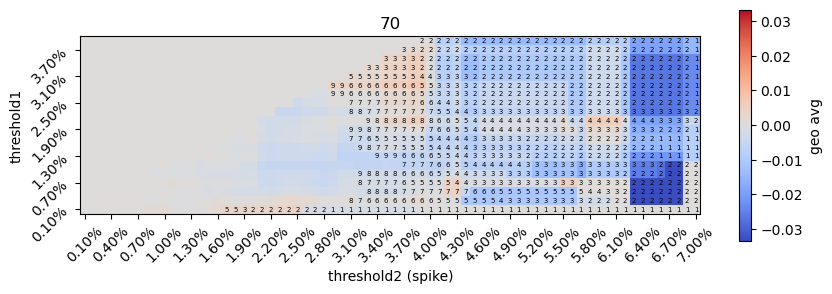

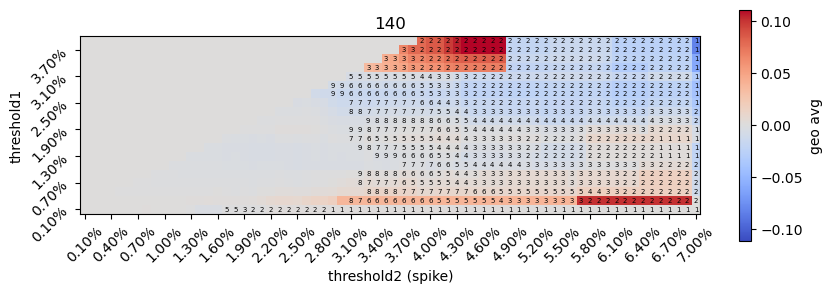

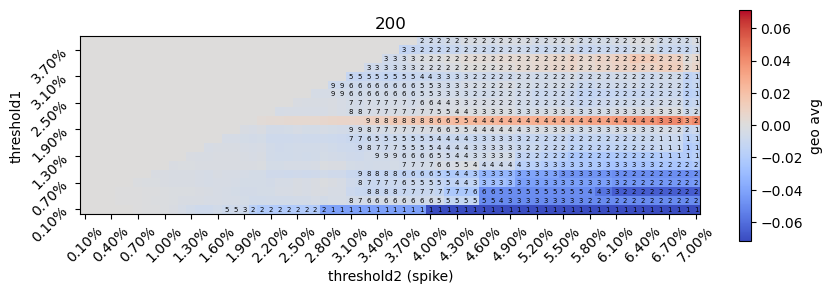

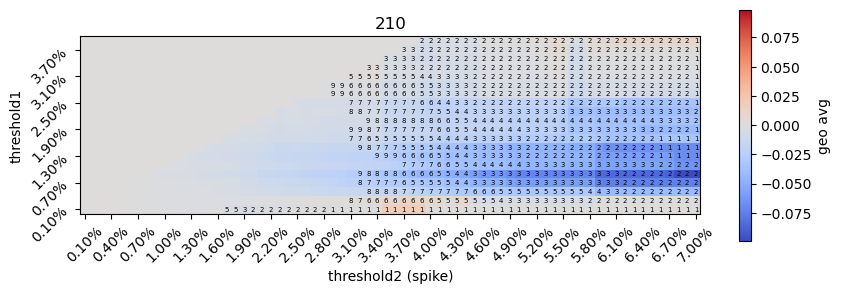

CPU times: total: 11.6 s
Wall time: 15.5 s


In [14]:
%%time
days=30 #[10,20,30,50,60,70,140,200,210]
for days in [10,20,30,50,60,70,140,200,210]:
    with open(f"9_0_5_analysisdata/slow_movement_then_large_ans_array_days{days:04d}_fast.pkl","rb") as f:
        ans_array = pickle.load(f)

    geo_avg_array= [[ 0 if len(ans_array[row][col])==1 else np.exp(np.log(np.product(1+np.asarray(ans_array[row][col])[1:]) )/(len(ans_array[row][col])-1))-1
                for col,_ in enumerate(threshold_2nd_list)] 
                for row,_ in enumerate(threshold_1st_list)]
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    plot_geo_avg_array(ax,geo_avg_array,threshold_2nd_list,threshold_1st_list)
    ax.set_ylabel("threshold1")
    ax.set_xlabel("threshold2 (spike)")
    ax.set_title(days)
    plt.show()

# seems like the profitable regions are inconsistent

# END OF FILE